KITTI DataLoader/Model

In [3]:
pip install yolov4


     ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
     --------- ------------------------------ 10.2/42.3 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.3 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 42.3/42.3 kB 345.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for yolov4: filename=yolov4-3.2.0-cp311-cp311-win_amd64.whl size=133600 sha256=13fa0280c4facc54601fbf3366a5f43308ccfe6291e3287b50ab62b5c239875f
  Stored in directory: c:\users\elisa\appdata\local\pip\cache\wheels\ac\d4\5a\997f84307294d97ca2222e16cd7b5f5482bf6e220f4c9f2570
Successfully built yolov4


2D object detection: 

5078
Image:  tf.Tensor(
[[[0.14253771 0.16069154 0.08510216]
  [0.11344998 0.12547636 0.06667034]
  [0.1015446  0.12557217 0.08569833]
  ...
  [0.05442112 0.0456755  0.02471934]
  [0.06477723 0.08858217 0.03984149]
  [0.12156387 0.13329832 0.04431327]]

 [[0.12286226 0.12068866 0.07246148]
  [0.08176505 0.11540249 0.07057073]
  [0.13361171 0.13846202 0.08109243]
  ...
  [0.04705328 0.04848853 0.02993088]
  [0.05097672 0.06270641 0.04311607]
  [0.08826502 0.08431398 0.05490196]]

 [[0.21383694 0.17065826 0.08165266]
  [0.11513332 0.13185632 0.06722134]
  [0.13424371 0.1208557  0.07718837]
  ...
  [0.04304217 0.04177171 0.02785598]
  [0.04751394 0.05672262 0.03630395]
  [0.06897725 0.06429631 0.04891878]]

 ...

 [[0.34944296 0.4511946  0.3923907 ]
  [0.12936847 0.2222505  0.22310969]
  [0.09283974 0.10143298 0.09829178]
  ...
  [0.14868364 0.1780626  0.12143455]
  [0.12212337 0.16378397 0.13988739]
  [0.14536981 0.17246118 0.15394403]]

 [[0.23686767 0.17380351 0.08725882]
  [0.09414914

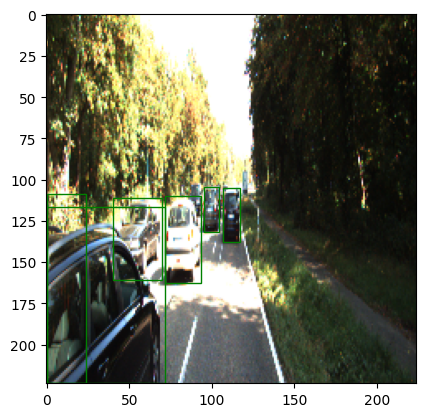

Epoch 1/5
 9/80 ━━━━━━━━━━━━━━━━━━━━ 14:55 13s/step - bbox_reshaped_mae: 0.2913 - label_reshaped_mae: 0.4703 - loss: 0.3923

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50
import numpy as np


def preprocess_image(image, bbox, label, input_shape):
    # Filter out non-car objects (car: type = 0)
    
    car_indices = tf.where(label == 0)[:, 0]
        
    bbox = tf.gather(bbox, car_indices)
    label = tf.gather(label, car_indices)
    
    # filter out images with more objects inside the image
    num_objects = tf.shape(bbox)[0]
    max_objects = 15
    # select max number of bboxes and orientation from the dataset
    bbox = tf.cond(num_objects <= max_objects,
                   lambda: bbox,
                   lambda: bbox[:max_objects])
    
    label = tf.cond(num_objects <= max_objects,
                   lambda: label,
                   lambda: label[:max_objects])
    
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255.0 

    # Handling multiple objects in a single image
    # Pad bounding boxes and orientations to a fixed number (16)
    bbox = tf.pad(bbox, [[0, 16 - tf.shape(bbox)[0]], [0, 0]], constant_values=0)
    label = tf.pad(label, [[0, 16 - tf.shape(label)[0]]], constant_values=1)

    return image, (bbox, label)

def preprocess(example, input_shape):
    # access relevant information only
    image = example['image']
    bbox = example['objects']['bbox']
    label = example['objects']['type']
    
    # Preprocess each image, bbox, label
    image, (bbox, label) = preprocess_image(image, bbox, label, input_shape)

    return image, (bbox, label)

def load_kitti_dataset(split, input_shape):
    # Load dataset
    dataset = tfds.load('kitti', split=split)

    # Apply preprocessing function to dataset
    dataset = dataset.map(lambda example: preprocess(example, input_shape))
   # dataset = dataset.filter(lambda image, labels: image is not None)


    return dataset

def VoxelRCNN(input_shape, num_classes=1):
    # Replace this with Voxel R-CNN backbone or a similar 3D convolutional backbone
    # For demonstration, use a simpler backbone (MobileNetV2) and adjust to your needs
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Remove the top classification layers
    backbone_output = backbone.output

    # Add custom head for object detection
    x = layers.GlobalAveragePooling2D()(backbone_output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)  # 16 bboxes, each with 4 coordinates (x, y, w, h)
    label_output = layers.Dense(16, activation = 'sigmoid', name="label_output")(x)
    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    label_output = layers.Reshape((16,), name="label_reshaped")(label_output)

    # Define the model
    model = tf.keras.Model(inputs=backbone.input, outputs=[bbox_output, label_output])

    return model

def create_model(input_shape):
    # To be changed: pre - trained model; used ResNet for testing purpose
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use pre-trained weights and only change those of final layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers for object detection
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)

    # shapes??????  - might have to adapt the shapes below  
    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)

    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)

    label_output = layers.Dense(16, activation = 'sigmoid', name="label_output")
    label_output = layers.Reshape((16,), name="label_reshaped")(label_output)


    # Define the model
    model = tf.keras.Model(inputs=base_model.input, outputs=[bbox_output, label_output])

    return model

def visualize_ground_truth(dataset):
    # Function to plot images with ground truth bounding boxes
    for image, (bbox_labels, orientation_labels) in dataset.take(1):
        print("Image: ", image[0], "bbox: ", bbox_labels[0])
        # Plot image with ground truth bounding boxes
        plot_image_with_bbox(image[0], bbox_labels[0], orientation_labels[0])

def plot_image_with_bbox(image, bboxes, orientations):
    height, width, _ = image.shape
    fig, ax = plt.subplots(1)
    
    ax.imshow(image)
    
    for bbox in bboxes:
        if tf.reduce_all(tf.equal(bbox, 0)):
            continue
        
        # KITTI bbox format: [left, top, right, bottom]        
        ymin = bbox[0] * height
        xmin = bbox[1] * width
        ymax = bbox[2] * height
        xmax = bbox[3] * width

        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        print("ymax", height - ymax)
        print("ymin", height - ymin)

        rect = patches.Rectangle((xmin, height - ymax), bbox_width, bbox_height, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
    

def main():
    # Input image shape
    input_shape = (224, 224, 3)

    # Create and compile the model
    # change the metrics and losses - did not find average precision as metric from tensorflow
    model = VoxelRCNN(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'bbox_reshaped': 'mean_squared_error', 'label_reshaped': 'binary_crossentropy'},
                  metrics={'bbox_reshaped': 'mae', 'label_reshaped': 'accuracy'})

    # Load and preprocess dataset
    train_dataset = load_kitti_dataset('train[:80%]', input_shape)
    test_dataset = load_kitti_dataset('train[80%:]', input_shape)
    print(len(train_dataset))
    
    # Apply padding and batching
    train_dataset = train_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16])))
    test_dataset = test_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16])))

    visualize_ground_truth(test_dataset)
    
    # Train the model
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)

if __name__ == "__main__":
    main()


3D object Detection

5078
Image:  tf.Tensor(
[[[0.14253771 0.16069154 0.08510216]
  [0.11344998 0.12547636 0.06667034]
  [0.1015446  0.12557217 0.08569833]
  ...
  [0.05442112 0.0456755  0.02471934]
  [0.06477723 0.08858217 0.03984149]
  [0.12156387 0.13329832 0.04431327]]

 [[0.12286226 0.12068866 0.07246148]
  [0.08176505 0.11540249 0.07057073]
  [0.13361171 0.13846202 0.08109243]
  ...
  [0.04705328 0.04848853 0.02993088]
  [0.05097672 0.06270641 0.04311607]
  [0.08826502 0.08431398 0.05490196]]

 [[0.21383694 0.17065826 0.08165266]
  [0.11513332 0.13185632 0.06722134]
  [0.13424371 0.1208557  0.07718837]
  ...
  [0.04304217 0.04177171 0.02785598]
  [0.04751394 0.05672262 0.03630395]
  [0.06897725 0.06429631 0.04891878]]

 ...

 [[0.34944296 0.4511946  0.3923907 ]
  [0.12936847 0.2222505  0.22310969]
  [0.09283974 0.10143298 0.09829178]
  ...
  [0.14868364 0.1780626  0.12143455]
  [0.12212337 0.16378397 0.13988739]
  [0.14536981 0.17246118 0.15394403]]

 [[0.23686767 0.17380351 0.08725882]
  [0.09414914

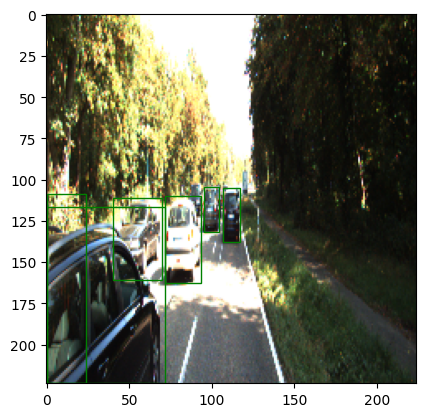

Epoch 1/5


KeyboardInterrupt: 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50
import numpy as np


def preprocess_image(image, bbox, label, orientation, input_shape):
    # Filter out non-car objects (car: type = 0)
    
    car_indices = tf.where(label == 0)[:, 0]

    # if tf.size(car_indices) == 0:
        
    bbox = tf.gather(bbox, car_indices)
    label = tf.gather(label, car_indices)
    orientation = tf.gather(orientation, car_indices)
    
    # filter out images with more objects inside the image
    num_objects = tf.shape(bbox)[0]
    max_objects = 15
    # select max number of bboxes and orientation from the dataset
    bbox = tf.cond(num_objects <= max_objects,
                   lambda: bbox,
                   lambda: bbox[:max_objects])
    orientation = tf.cond(num_objects <= max_objects,
                          lambda: orientation,
                          lambda: orientation[:max_objects])
    
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255.0 

    # Handling multiple objects in a single image
    # Pad bounding boxes and orientations to a fixed number (16)
    bbox = tf.pad(bbox, [[0, 16 - tf.shape(bbox)[0]], [0, 0]], constant_values=0)
    orientation = tf.pad(orientation, [[0, 16 - tf.shape(orientation)[0]], [0, 0]], constant_values=0)

    return image, (bbox, orientation)

def preprocess(example, input_shape):
    # access relevant information only
    image = example['image']
    bbox = example['objects']['bbox']
    label = example['objects']['type']
    orientation = example['objects']['dimensions']
    
    # Preprocess each image, bbox, label
    image, (bbox, orientation) = preprocess_image(image, bbox, label, orientation, input_shape)

    return image, (bbox, orientation)

def load_kitti_dataset(split, input_shape):
    # Load dataset
    dataset = tfds.load('kitti', split=split)

    # Apply preprocessing function to dataset
    dataset = dataset.map(lambda example: preprocess(example, input_shape))
   # dataset = dataset.filter(lambda image, labels: image is not None)


    return dataset

def VoxelRCNN(input_shape, num_classes=1):
    # Replace this with Voxel R-CNN backbone or a similar 3D convolutional backbone
    # For demonstration, use a simpler backbone (MobileNetV2) and adjust to your needs
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Remove the top classification layers
    backbone_output = backbone.output

    # Add custom head for object detection
    x = layers.GlobalAveragePooling2D()(backbone_output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)  # 16 bboxes, each with 4 coordinates (x, y, w, h)
    orientation_output = layers.Dense(16 * 3, name='orientation_output')(x)  # 16 orientations, each with 3 dimensions

    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    orientation_output = layers.Reshape((16, 3), name="orientation_reshaped")(orientation_output)

    # Define the model
    model = tf.keras.Model(inputs=backbone.input, outputs=[bbox_output, orientation_output])

    return model

def create_model(input_shape):
    # To be changed: pre - trained model; used ResNet for testing purpose
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use pre-trained weights and only change those of final layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers for object detection
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)

    # shapes??????  - might have to adapt the shapes below  
    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)
    orientation_output = layers.Dense(16 * 3, name='orientation_output')(x)

    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    orientation_output = layers.Reshape((16, 3),name="orientation_reshaped")(orientation_output)

    # Define the model
    model = tf.keras.Model(inputs=base_model.input, outputs=[bbox_output, orientation_output])

    return model

def visualize_ground_truth(dataset):
    # Function to plot images with ground truth bounding boxes
    for image, (bbox_labels, orientation_labels) in dataset.take(1):
        print("Image: ", image[0], "bbox: ", bbox_labels[0])
        # Plot image with ground truth bounding boxes
        plot_image_with_bbox(image[0], bbox_labels[0], orientation_labels[0])

def plot_image_with_bbox(image, bboxes, orientations):
    height, width, _ = image.shape
    fig, ax = plt.subplots(1)
    
    ax.imshow(image)
    
    for bbox in bboxes:
        if tf.reduce_all(tf.equal(bbox, 0)):
            continue
        
        # KITTI bbox format: [left, top, right, bottom]        
        ymin = bbox[0] * height
        xmin = bbox[1] * width
        ymax = bbox[2] * height
        xmax = bbox[3] * width

        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        print("ymax", height - ymax)
        print("ymin", height - ymin)

        rect = patches.Rectangle((xmin, height - ymax), bbox_width, bbox_height, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
    

def main():
    # Input image shape
    input_shape = (224, 224, 3)

    # Create and compile the model
    # change the metrics and losses - did not find average precision as metric from tensorflow
    model = VoxelRCNN(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'bbox_reshaped': 'mean_squared_error', 'orientation_reshaped': 'mean_squared_error'},
                  metrics={'bbox_reshaped': 'mae', 'orientation_reshaped': 'mae'})

    # Load and preprocess dataset
    train_dataset = load_kitti_dataset('train[:80%]', input_shape)
    test_dataset = load_kitti_dataset('train[80%:]', input_shape)
    print(len(train_dataset))
    
    # Apply padding and batching
    train_dataset = train_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16, 3])))
    test_dataset = test_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16, 3])))

    visualize_ground_truth(test_dataset)
    
    # Train the model
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)

if __name__ == "__main__":
    main()


Virtual KITTI Dataloader

2D Object Detection


In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def read_and_preprocess_image(filename, input_shape):
    image = Image.open(filename)
    image = image.resize((input_shape[1], input_shape[0]))  # 1st width, 2nd height
    image = np.array(image) / 255.0  # normalize as above
    return image

def data_generator(grouped_data, input_shape):
    for filename, bboxes, labels in grouped_data:
        image = read_and_preprocess_image(filename, input_shape)
        yield image, (bboxes.astype(np.int32), labels.astype(np.int32))

# generate virtual kitti csv file to not read over and over through the folders when training
# base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt'
# img_base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb'

def adjust_bboxes(bboxes, original_shape, input_shape):
    height_ratio = original_shape[0] / input_shape[0]
    width_ratio = original_shape[1] / input_shape[1]
    
    adjusted_bboxes = bboxes.astype(np.float32).copy()
    adjusted_bboxes[:, [0, 1]] = (adjusted_bboxes[:, [0, 1]] / height_ratio).astype(np.int32)
    adjusted_bboxes[:, [2, 3]] = (adjusted_bboxes[:, [2, 3]] / width_ratio).astype(np.int32)
    
    return adjusted_bboxes

def save_padded_data_to_csv(padded_data, csv_filename):
    data_records = []
    for filename, bboxes, labels in padded_data:
        for i in range(len(bboxes)):
            bbox = bboxes[i]
            label = labels[i]
            record = [filename] + bbox.tolist() + [label]
            data_records.append(record)
    
    df = pd.DataFrame(data_records, columns=['filename', 'left', 'right', 'top', 'bottom', 'label'])
    df.to_csv(csv_filename, index=False)
    
def load_virtual_kitti_dataset(base_folder, img_base_folder, input_shape, original_shape):
    scenes = ['Scene20']#, 'Scene02', 'Scene06', 'Scene18', 'Scene20']
    variations = ['fog', 'clone', 'morning', 'overcast', 'rain', 'sunset']

    image_filenames = []
    bbox_data_list = []

    for scene in scenes:
        for variation in variations:
            image_folder = os.path.join(img_base_folder, scene, variation, 'frames', 'rgb', 'Camera_0')
            bbox_file = os.path.join(base_folder, scene, variation, 'bbox.txt')
        
            current_image_filenames = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')])
            image_filenames.extend(current_image_filenames)

            current_bbox_data = pd.read_csv(bbox_file, delim_whitespace=True)
            current_bbox_data = current_bbox_data[current_bbox_data['cameraID'] == 0]  # Filter for cameraID == 0
            bbox_data_list.append(current_bbox_data)

    if not image_filenames or not bbox_data_list:
        raise ValueError("No image or bounding box data found. Check the dataset paths.")

    bbox_data = pd.concat(bbox_data_list, ignore_index=True)
    
    #print(bbox_data)
    grouped_data = []
    for filename in image_filenames:
        frame_id = os.path.splitext(os.path.basename(filename))[0]
        frame_id_original = int(frame_id.split('_')[-1])
        # Selecting camera 0's bounding boxes for the given frame
        
        if frame_id_original in bbox_data['frame'].values:
            bboxes = bbox_data[bbox_data['frame'] == frame_id_original][['left', 'right', 'top', 'bottom']].values
            bboxes = adjust_bboxes(bboxes, original_shape, input_shape)
        else:
            bboxes = np.zeros((1, 4), dtype=np.float32)
        grouped_data.append((filename, bboxes))
    
    padded_data = []
    max_objects = 16  # Maximum number of objects per image (bboxes and orientations) - need to be adjusted!!!
    for filename, bboxes in grouped_data:
        padded_bboxes = np.zeros((max_objects, 4), dtype=np.float32)
        padded_labels = np.ones((max_objects,), dtype=np.int32) 
               
        num_bboxes = min(max_objects, bboxes.shape[0])
        
        padded_bboxes[:num_bboxes, :] = bboxes[:num_bboxes, :]
        padded_labels[:num_bboxes] = 0  
              
        padded_data.append((filename, padded_bboxes, padded_labels))
        
    save_padded_data_to_csv(padded_data, "C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene20.csv")

    dataset = tf.data.Dataset.from_generator(lambda: data_generator(padded_data, input_shape),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None,), dtype=tf.int32))))
    return dataset

def load_virtual_kitti_dataset_csv(csv_filename, input_shape):
    # Load data from CSV
    padded_data = pd.read_csv(csv_filename)
    
    grouped_data = []
    for filename, group in padded_data.groupby('filename'):
        bboxes = group[['left', 'right', 'top', 'bottom']].values
        labels = group['label'].values
        grouped_data.append((filename, bboxes, labels))
    
    dataset = tf.data.Dataset.from_generator(lambda: data_generator(grouped_data, input_shape),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.int32),
                                                                tf.TensorSpec(shape=(None,), dtype=tf.int32))))
    num_samples = len(grouped_data)
    train_size = int(num_samples * 0.7)
    
    # Shuffle the dataset before splitting
    dataset = dataset.shuffle(num_samples, reshuffle_each_iteration=False)

    # Split into training and testing datasets
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    return train_dataset, test_dataset


def VoxelRCNN(input_shape, num_classes=1):
    # Replace this with Voxel R-CNN backbone or a similar 3D convolutional backbone
    # For demonstration, use a simpler backbone (MobileNetV2) and adjust to your needs
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Remove the top classification layers
    backbone_output = backbone.output

    # Add custom head for object detection
    x = layers.GlobalAveragePooling2D()(backbone_output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)  # 16 bboxes, each with 4 coordinates (x, y, w, h)
    label_output = layers.Dense(16, activation = 'sigmoid', name="label_output")(x)
    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    label_output = layers.Reshape((16,), name="label_reshaped")(label_output)

    # Define the model
    model = tf.keras.Model(inputs=backbone.input, outputs=[bbox_output, label_output])

    return model

def visualize_ground_truth(dataset):
    dataset = dataset.shuffle(buffer_size=len(list(dataset)))
    fig, axes = plt.subplots(1, 10, figsize=(25, 10))  # Create 5 subplots in a row

    for i, (image, (bbox, orientation)) in enumerate(dataset.take(10)):
        ax = axes[i]
        ax.imshow(image.numpy())
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')

        for bbox_label in bbox.numpy():
            if np.all(bbox_label == 0):
                continue
            left, right, top, bottom = bbox_label
            bbox_width = right - left
            bbox_height = bottom - top
    
            rect = patches.Rectangle((left, top), bbox_width, bbox_height, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


def main():

    csv_file = r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_allscenes.csv"
    # base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt'
    # img_base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb'
    # image_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb\Scene01\15-deg-left\frames\rgb\Camera_0'
    # bbox_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\bbox.txt'
    # pose_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\pose.txt'

    input_shape = (224,224, 3)
    original_shape = (1242, 375)

    #train_dataset, test_dataset 
    train_dataset, test_dataset = load_virtual_kitti_dataset_csv(csv_file, input_shape) #, original_shape)

    visualize_ground_truth(train_dataset)
    print("Dataset:", train_dataset)
    
    model = VoxelRCNN(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'bbox_reshaped': 'mean_squared_error', 'label_reshaped': 'binary_crossentropy'},
                  metrics={'bbox_reshaped': 'mae', 'label_reshaped': 'accuracy'})

    # Train the model
    model.fit(train_dataset.batch(32), epochs=15) #, validation_data=test_dataset)  

if __name__ == "__main__":
    main()


(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(1242, 375)
(124

In [1]:
# generate virtual kitti csv file to not read over and over through the folders when training
# base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt'
# img_base_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb'

def adjust_bboxes(bboxes, original_shape, input_shape):
    height_ratio = original_shape[0] / input_shape[0]
    width_ratio = original_shape[1] / input_shape[1]
    
    adjusted_bboxes = bboxes.astype(np.float32).copy()
    adjusted_bboxes[:, [0, 1]] = (adjusted_bboxes[:, [0, 1]] / height_ratio).astype(np.int32)
    adjusted_bboxes[:, [2, 3]] = (adjusted_bboxes[:, [2, 3]] / width_ratio).astype(np.int32)
    
    return adjusted_bboxes

def save_padded_data_to_csv(padded_data, csv_filename):
    data_records = []
    for filename, bboxes, labels in padded_data:
        for i in range(len(bboxes)):
            bbox = bboxes[i]
            label = labels[i]
            record = [filename] + bbox.tolist() + [label]
            data_records.append(record)
    
    df = pd.DataFrame(data_records, columns=['filename', 'left', 'right', 'top', 'bottom', 'label'])
    df.to_csv(csv_filename, index=False)
    
def load_virtual_kitti_dataset(base_folder, img_base_folder, input_shape, original_shape):
    scenes = ['Scene01', 'Scene02', 'Scene06', 'Scene18', 'Scene20']
    variations = ['clone', 'fog', 'morning', 'overcast', 'rain', 'sunset']

    image_filenames = []
    bbox_data_list = []

    for scene in scenes:
        for variation in variations:
            image_folder = os.path.join(img_base_folder, scene, variation, 'frames', 'rgb', 'Camera_0')
            bbox_file = os.path.join(base_folder, scene, variation, 'bbox.txt')
            print(image_folder)
            current_image_filenames = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')])
            image_filenames.extend(current_image_filenames)

            current_bbox_data = pd.read_csv(bbox_file, delim_whitespace=True)
            current_bbox_data = current_bbox_data[current_bbox_data['cameraID'] == 0]  # Filter for cameraID == 0
            print(current_bbox_data, current_image_filenames)
            bbox_data_list.append(current_bbox_data)

    if not image_filenames or not bbox_data_list:
        raise ValueError("No image or bounding box data found. Check the dataset paths.")

    bbox_data = pd.concat(bbox_data_list, ignore_index=True)
    
    #print(bbox_data)
    grouped_data = []
    for filename in image_filenames:
        frame_id = os.path.splitext(os.path.basename(filename))[0]
        frame_id_original = int(frame_id.split('_')[-1])
        print("ID: ", frame_id_original, "frame_cal:", bbox_data['frame'].values)
        # Selecting camera 0's bounding boxes for the given frame
        
        if frame_id_original in bbox_data['frame'].values:
            bboxes = bbox_data[bbox_data['frame'] == frame_id_original][['left', 'right', 'top', 'bottom']].values
            bboxes = adjust_bboxes(bboxes, original_shape, input_shape)
        else:
            bboxes = np.zeros((1, 4), dtype=np.float32)
        grouped_data.append((filename, bboxes))
    
    padded_data = []
    max_objects = 16  # Maximum number of objects per image (bboxes and orientations)
    for filename, bboxes in grouped_data:
        padded_bboxes = np.zeros((max_objects, 4), dtype=np.float32)
        padded_labels = np.ones((max_objects,), dtype=np.int32) 
               
        num_bboxes = min(max_objects, bboxes.shape[0])
        
        padded_bboxes[:num_bboxes, :] = bboxes[:num_bboxes, :]
        padded_labels[:num_bboxes] = 0  
              
        padded_data.append((filename, padded_bboxes, padded_labels))
        
    save_padded_data_to_csv(padded_data, "C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti.csv")

    dataset = tf.data.Dataset.from_generator(lambda: data_generator(padded_data, input_shape),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None,), dtype=tf.int32))))
    return dataset

In [1]:
import pandas as pd
import os

def concatenate_csv_files(csv_files):
    dataframes = []
    
    # Read each CSV file and append the DataFrame to the list
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    
    # Concatenate all DataFrames
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

# List of CSV files to concatenate
csv_files = [
    r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene1.csv",
    r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene2.csv",
    r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene6.csv",
    r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene18.csv",
    r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_scene20.csv",
]

# Concatenate the CSV files
concatenated_df = concatenate_csv_files(csv_files)

# Optionally, save the concatenated DataFrame to a new CSV file
concatenated_df.to_csv(r"C:\Arbeitsordner\Abgaben_repo\padded_data_vkitti_allscenes.csv", index=False)

# Print the concatenated DataFrame
print(concatenated_df)


                                                 filename   left  right  \
0       C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...  139.0  223.0   
1       C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...  130.0  156.0   
2       C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...  125.0  139.0   
3       C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...   71.0   85.0   
4       C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...   91.0   97.0   
...                                                   ...    ...    ...   
204091  C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...  103.0  120.0   
204092  C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...    0.0    0.0   
204093  C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...    0.0    0.0   
204094  C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...    0.0    0.0   
204095  C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb...    0.0    0.0   

          top  bottom  label  
0       100.0   223.0      0  
1       111.0   167.0      0  
2     

3D Object Detection

0          0
1          0
2          0
3          0
4          0
        ... 
14239    423
14240    424
14241    424
14242    425
14243    425
Name: frame, Length: 14244, dtype: int64
       frame  cameraID  trackID  left  right  top  bottom  number_pixels  \
0          0         0        0   988   1241  159     374          41767   
1          0         0        1   927   1102  171     275           7168   
2          0         0        2   897    984  171     236           2603   
3          0         0        3   591    666  187     239           2311   
4          0         0        4   699    732  181     206            452   
...      ...       ...      ...   ...    ...  ...     ...            ...   
14239    423         1       86     0    416  203     374          50535   
14240    424         0       86     0    429  205     374          53967   
14241    424         1       86     0    385  205     374          50154   
14242    425         0       86     0    397  207     37

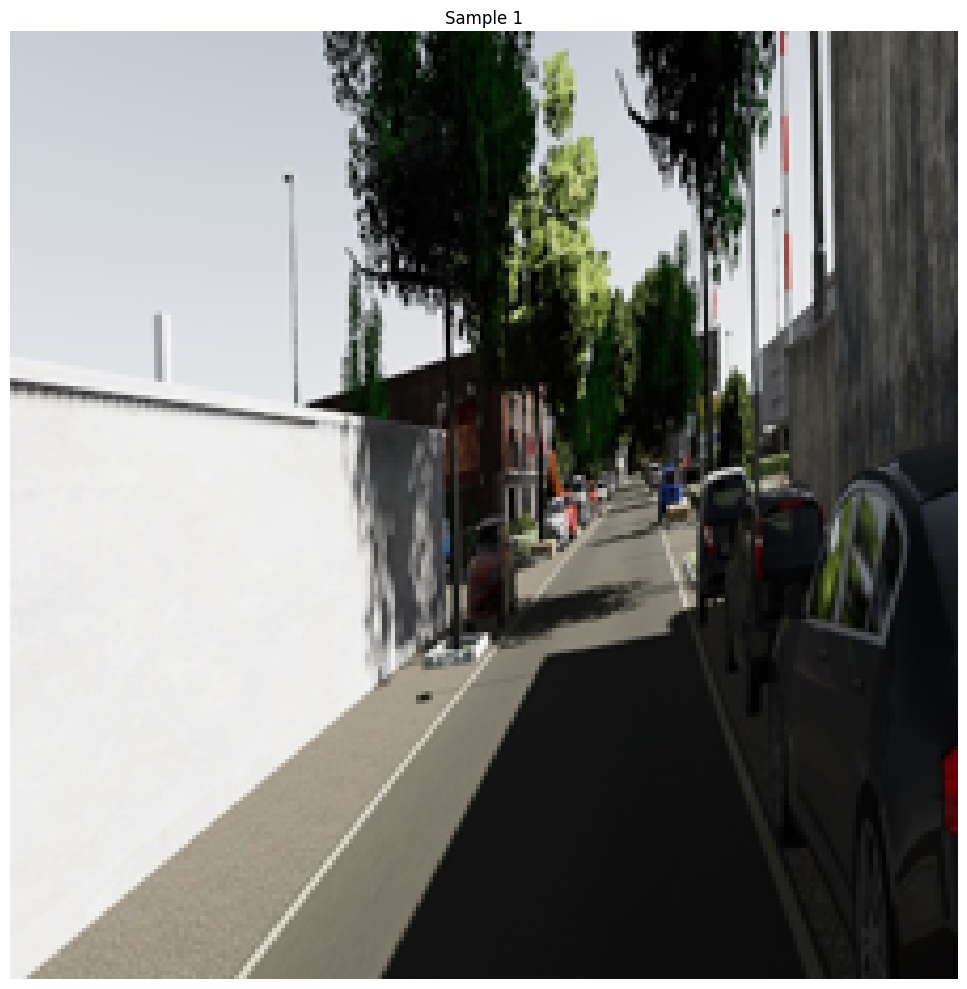

Dataset: <_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)))>
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - bbox_reshaped_mae: 409.5966 - loss: 290857.7188 - orientation_reshaped_mae: 2.2362
Epoch 2/5


c:\Users\elisa\miniconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 2/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - bbox_reshaped_mae: 468.5486 - loss: 320880.8438 - orientation_reshaped_mae: 4.2146 

KeyboardInterrupt: 

In [18]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches



def read_and_preprocess_image(filename, input_shape):
    image = Image.open(filename)
    image = image.resize((input_shape[1], input_shape[0]))  # 1st width, 2nd height
    image = np.array(image) / 255.0  # normalize as above
    return image


def data_generator(grouped_data, input_shape):
    for filename, bboxes, orientations in grouped_data:
        image = read_and_preprocess_image(filename, input_shape)
        yield image, (bboxes.astype(np.int32), orientations.astype(np.float32))

def load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape):
    image_filenames = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')])

    bbox_data = pd.read_csv(bbox_file, delim_whitespace=True)
    print(bbox_data["frame"])

    # Read pose data and select required columns
    pose_data = pd.read_csv(pose_file, delim_whitespace=True)

    print(bbox_data)
    grouped_data = []
    for filename in image_filenames:
        frame_id = os.path.splitext(os.path.basename(filename))[0]
        frame_id_original = int(frame_id.split('_')[-1])

        # Selecting camera 0's bounding boxes for the given frame
        if frame_id_original in bbox_data[bbox_data['cameraID'] == 0]['frame'].values:
            bboxes = bbox_data[(bbox_data['frame'] == frame_id_original) & (bbox_data['cameraID'] == 0)][['left', 'right', 'top', 'bottom']].values
        else:
            bboxes = np.zeros((1, 4), dtype=np.float32)

        # Selecting all orientations for the given frame
        if frame_id_original in pose_data[pose_data['cameraID'] == 0]['frame'].values:
            orientations = pose_data[(pose_data['frame'] == frame_id_original) & (pose_data['cameraID'] == 0)][['width', 'height', 'length']].values
        else:
            orientations = np.zeros((1, 3), dtype=np.float32)

        grouped_data.append((filename, bboxes, orientations))
    
    padded_data = []
    max_objects = 16  # Maximum number of objects per image (bboxes and orientations)
    for filename, bboxes, orientations in grouped_data:
        padded_bboxes = np.zeros((max_objects, 4), dtype=np.float32)
        padded_orientations = np.zeros((max_objects, 3), dtype=np.float32)
        
        num_bboxes = min(max_objects, bboxes.shape[0])
        num_orientations = min(max_objects, orientations.shape[0])
        
        padded_bboxes[:num_bboxes, :] = bboxes[:num_bboxes, :]
        padded_orientations[:num_orientations, :] = orientations[:num_orientations, :]
        
        padded_data.append((filename, padded_bboxes, padded_orientations))

    dataset = tf.data.Dataset.from_generator(lambda: data_generator(padded_data, input_shape),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None, 3), dtype=tf.float32))))
    return dataset


def VoxelRCNN(input_shape, num_classes=1):
    # For demonstration, using a simple model - should change this to MobileNetv2 as above
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Output layers for bounding box regression and orientation prediction
    bbox_output = tf.keras.layers.Dense(16 * 4, name='bbox_output')(x)  
    orientation_output = tf.keras.layers.Dense(16 * 3, name='orientation_output')(x)  

    # Reshape the outputs - same as for kitti
    bbox_output = tf.keras.layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    orientation_output = tf.keras.layers.Reshape((16, 3), name="orientation_reshaped")(orientation_output)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=[bbox_output, orientation_output])

    return model


def visualize_ground_truth(dataset):
    fig, axes = plt.subplots( 1, figsize=(10, 10))

    for i, (image, (bbox, orientation)) in enumerate(dataset.take(1)):
        axes.imshow(image.numpy())
        axes.set_title(f"Sample {i+1}")
        axes.axis('off')

        for bbox_label in bbox.numpy():
            if np.all(bbox_label == 0):
                continue
            print("label", bbox_label)
            left, right, top, bottom = bbox_label
            bbox_width = right - left
            bbox_height = bottom - top
            rect = patches.Rectangle((left, top), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
            axes.add_patch(rect)

    plt.tight_layout()
    plt.show()

def main():

    image_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb\Scene01\15-deg-left\frames\rgb\Camera_0'
    bbox_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\bbox.txt'
    pose_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\pose.txt'

    input_shape = (224, 224, 3)



    dataset = load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape)

    visualize_ground_truth(dataset)
    print("Dataset:", dataset)
    
    model = VoxelRCNN(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'bbox_reshaped': 'mean_squared_error', 'orientation_reshaped': 'mean_squared_error'},
                  metrics={'bbox_reshaped': 'mae', 'orientation_reshaped': 'mae'})

    # Train the model
    model.fit(dataset.batch(32), epochs=5)  

    # troubleshooting
    for image, (bbox, pose) in dataset.take(5):
        print("Image shape:", image.shape)
        print("Bounding Box:", bbox.numpy())
        print("Pose:", pose.numpy())

if __name__ == "__main__":
    main()


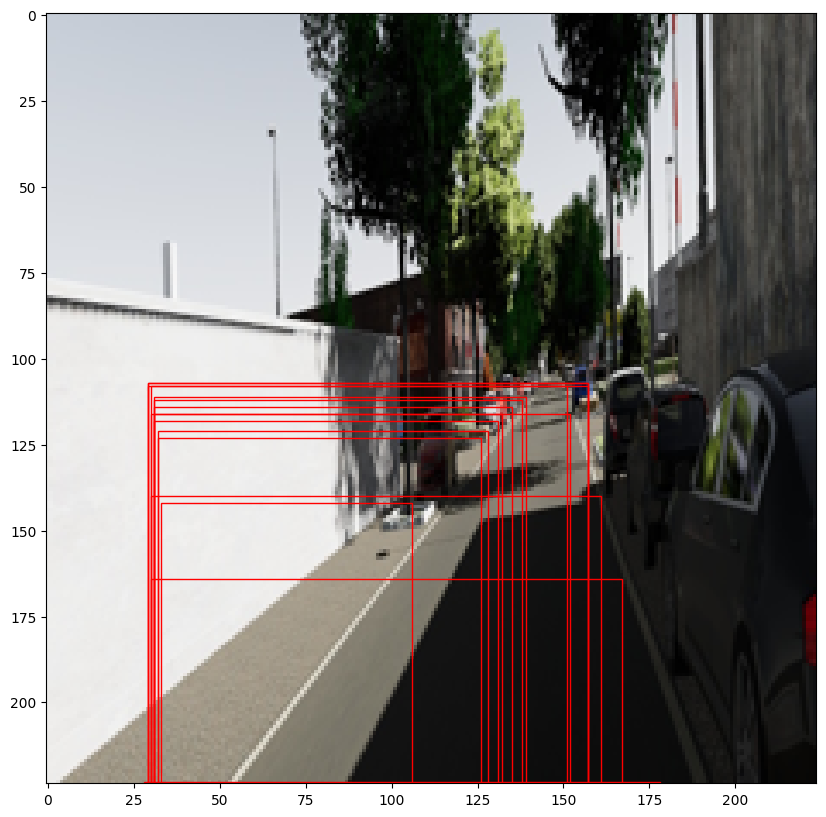

Dataset: <_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)))>
Image shape: (224, 224, 3)
Bounding Box: [[ 32. 442.   5. 133.]
 [ 30. 393.   5.  98.]
 [ 29. 351.   5.  84.]
 [ 19. 237.   6.  85.]
 [ 22. 261.   5.  73.]
 [ 27. 314.   5.  69.]
 [ 23. 265.   5.  72.]
 [ 23. 269.   5.  70.]
 [ 23. 271.   5.  69.]
 [ 24. 274.   5.  68.]
 [ 27. 304.   5.  64.]
 [ 28. 327.   5.  64.]
 [ 28. 325.   5.  64.]
 [ 25. 280.   5.  66.]
 [ 24. 279.   5.  67.]
 [ 28. 323.   5.  64.]]
Pose: [[1.85     1.50992  4.930564]
 [1.612032 1.404795 3.772344]
 [1.567278 1.413269 3.158158]
 [1.555003 1.527328 3.576751]
 [1.540477 1.417371 3.504343]
 [1.746308 1.512623 3.775172]
 [1.513462 1.360295 4.017023]
 [1.652467 1.73687  4.107703]
 [1.638188 1.609242 3.998   ]
 [1.697305 1.431419 3.744055]
 [1.6639   1.546081 4.146974]
 [1.69797  1.473782 4.648869]
 [1

In [4]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def read_and_preprocess_image(filename, input_shape):
    image = Image.open(filename)
    image = image.resize((input_shape[1], input_shape[0]))  # 1st width, 2nd height
    image = np.array(image) / 255.0  # normalize as above
    return image

def data_generator(grouped_data, input_shape, original_image_size):
    for filename, bboxes, orientations in grouped_data:
        image = read_and_preprocess_image(filename, input_shape)
        bboxes = resize_bboxes(bboxes, original_image_size, input_shape)
        yield image, (bboxes.astype(np.int32), orientations.astype(np.float32))

def resize_bboxes(bboxes, original_image_size, new_image_size):
    original_height, original_width = original_image_size
    new_height, new_width = new_image_size[:2]
    
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * new_width / original_width  # x-coordinates ?? 
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * new_height / original_height  # y-coordinates ?? how to adjust bboxes to the reshaped image (pixel values)
    
    return bboxes

def load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape, original_image_size):
    image_filenames = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')])

    bbox_data = pd.read_csv(bbox_file, delim_whitespace=True)
    pose_data = pd.read_csv(pose_file, delim_whitespace=True)

    grouped_data = []
    for filename in image_filenames:
        frame_id = os.path.splitext(os.path.basename(filename))[0]
        frame_id_original = int(frame_id.split('_')[-1])

        if frame_id_original in bbox_data[bbox_data['cameraID'] == 0]['frame'].values:
            bboxes = bbox_data[(bbox_data['frame'] == frame_id_original) & (bbox_data['cameraID'] == 0)][['left', 'right', 'top', 'bottom']].values
        else:
            bboxes = np.zeros((1, 4), dtype=np.float32)

        if frame_id_original in pose_data[pose_data['cameraID'] == 0]['frame'].values:
            orientations = pose_data[(pose_data['frame'] == frame_id_original) & (pose_data['cameraID'] == 0)][['width', 'height', 'length']].values
        else:
            orientations = np.zeros((1, 3), dtype=np.float32)

        grouped_data.append((filename, bboxes, orientations))
    
    padded_data = []
    max_objects = 16
    for filename, bboxes, orientations in grouped_data:
        padded_bboxes = np.zeros((max_objects, 4), dtype=np.float32)
        padded_orientations = np.zeros((max_objects, 3), dtype=np.float32)
        
        num_bboxes = min(max_objects, bboxes.shape[0])
        num_orientations = min(max_objects, orientations.shape[0])
        
        padded_bboxes[:num_bboxes, :] = bboxes[:num_bboxes, :]
        padded_orientations[:num_orientations, :] = orientations[:num_orientations, :]
        
        padded_data.append((filename, padded_bboxes, padded_orientations))

    dataset = tf.data.Dataset.from_generator(lambda: data_generator(padded_data, input_shape, original_image_size),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None, 3), dtype=tf.float32))))
    return dataset

def plot_image_with_bbox(image, bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    ax.imshow(image)
    
    for bbox in bboxes:
        if np.all(bbox == 0):
            continue
        
        xmin, ymin, xmax, ymax = bbox

        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        
        rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

def visualize_ground_truth(dataset):
    for image, (bboxes, _) in dataset.take(1):
        image = image.numpy()
        bboxes = bboxes.numpy()
        plot_image_with_bbox(image, bboxes)

def main():
    image_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb\Scene01\15-deg-left\frames\rgb\Camera_0'
    bbox_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\bbox.txt'
    pose_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\pose.txt'
    
    input_shape = (224, 224, 3)
    # to compute bboxes for reshaped image
    original_image_size = (375, 1242)  

    dataset = load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape, original_image_size)
    visualize_ground_truth(dataset)
    print("Dataset:", dataset)
    
   
    for image, (bbox, pose) in dataset.take(5):
        print("Image shape:", image.shape)
        print("Bounding Box:", bbox.numpy())
        print("Pose:", pose.numpy())

if __name__ == "__main__":
    main()
